<a href="https://colab.research.google.com/github/Fikaaw/amazing-feat-eng/blob/main/feat_eng1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder, TargetEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
df = pd.read_csv('D:/Belajar python/data-analytics-competition-find-it-2024/train_features.csv')
test = pd.read_csv('D:/Belajar python/data-analytics-competition-find-it-2024/test_features.csv')
submission = pd.read_csv('D:/Belajar python/data-analytics-competition-find-it-2024/submission_format.csv')
df_label = pd.read_csv('D:/Belajar python/data-analytics-competition-find-it-2024/train_labels.csv')
df = pd.concat([df, df_label], axis=1)
df.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05,2
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17,0
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN,1
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN,4
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN,4


In [ ]:
def get_num_child(data):
    x = data.copy()
    x['jumlah_anak'] = x['jumlah_anak_balita'] + x['jumlah_anak_remaja']
    return x

def get_total_purchase(data):
    x = data.copy()
    x['total_pembelian'] = x['pembelian_web'] + x['pembelian_toko']
    return x

def get_total_charge(data):
    x = data.copy()
    x['total_belanja'] = x['belanja_buah'] + x['belanja_daging'] + x['belanja_ikan'] + x['belanja_kue']
    return x

def get_percentage_cost(data):
    x = data.copy()
    x['presentase_pengeluaran'] = (x['belanja_buah'] + x['belanja_daging'] + x['belanja_ikan'] + x['belanja_kue'])/x['pendapatan']
    return x

def get_remains_of_income(data):
    x = data.copy()
    x['sisa_penghasilan'] = x['pendapatan'] - (x['belanja_buah'] + x['belanja_daging'] + x['belanja_ikan'] + x['belanja_kue'])
    return x

def get_date(data):
    x = data.copy()
    x['tanggal_menjadi_anggota'] = pd.to_datetime(x['tanggal_menjadi_anggota'])
    x['hari'] = x['tanggal_menjadi_anggota'].dt.day
    x['bulan'] = x['tanggal_menjadi_anggota'].dt.month
    x['tahun'] = x['tanggal_menjadi_anggota'].dt.year
    return x

def get_feature_engineering(data):
    x = data.copy()
    x = get_num_child(x)
    x = get_total_purchase(x)
    x = get_total_charge(x)
    x = get_percentage_cost(x)
    x = get_remains_of_income(x)
    x = get_date(x)
    return x

df = get_feature_engineering(df)


In [ ]:
test = get_feature_engineering(test)

## hajar

In [ ]:
X = df.drop(['jumlah_promosi','tanggal_menjadi_anggota'], axis=1)
y = df['jumlah_promosi']

X.shape, y.shape

((3817, 23), (3817,))

In [ ]:
# Custom Imputer and Scaler
class StochasticImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='stochastic'):
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.strategy != 'stochastic':
            raise ValueError("Invalid strategy; only 'stochastic' is supported.")
        self.distributions_ = {}
        for col in X.columns:
            self.distributions_[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_imputed = X.copy()
        for col in X.columns:
            missing = X_imputed[col].isnull()
            if missing.sum() > 0:
                impute_values = np.random.choice(self.distributions_[col].index,
                                                 size=missing.sum(),
                                                 p=self.distributions_[col].values)
                X_imputed.loc[missing, col] = impute_values
        return X_imputed

    def get_feature_names_out(self):
        pass

class ClassMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        # Calculate mean for each class
        self.means_ = X.groupby(y).transform('mean')
        return self

    def transform(self, X):
        return X.fillna(self.means_)

    def get_feature_names_out(self):
        pass

class ClassMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.medians_ = X.groupby(y).transform('median')
        return self

    def transform(self, X):
        return X.fillna(self.medians_)

    def get_feature_names_out(self):
        pass

class CategoryMostFrequentImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.most_frequent_ = X.groupby(y).transform(lambda x: x.mode()[0])
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame.")
        return X.fillna(self.most_frequent_)

    def get_feature_names_out(self):
        pass

class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log10(X + 1)

    def get_feature_names_out(self):
        pass

class CosineScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Calculate the maximum value for each feature
        self.max_values_ = X.max(axis=0) - 1
        return self

    def transform(self, X):
        # Subtract 1 from each value
        X = X - 1
        # Calculate the cosine of each scaled value
        X_cosine = np.cos(X * 2 * np.pi/self.max_values_)
        return X_cosine

    def get_feature_names_out(self):
        pass

In [ ]:
# Pipeline
birthdate_cols = ['tahun_kelahiran'] # simple imputer with median
cat_cols = ['pendidikan','status_pernikahan',  'keluhan'] # target encoder with MostFrequentImputer
float_cols = ['pendapatan', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue',
              'total_belanja', 'sisa_penghasilan', 'presentase_pengeluaran'] # mean imputer with log transformation
int_cols = ['jumlah_anak_balita', 'jumlah_anak_remaja', 'pembelian_web', 'pembelian_toko',
            'pembelian_diskon','jumlah_anak','total_pembelian', 'terakhir_belanja'] # median imputer
date_cols = ['hari', 'bulan'] # stochastic imputer with cosine scaler
year_cols = ['tahun'] # stochastic imputer

birthdate_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
    ('imputer', CategoryMostFrequentImputer()),
    ('encoder', TargetEncoder(target_type='continuous'))
])

float_pipeline = Pipeline([
    ('imputer', ClassMeanImputer()),
    ('log_scaler', LogScaler())
])

int_pipeline = Pipeline([
    ('imputer', ClassMedianImputer())
])

date_pipeline = Pipeline([
    ('imputer', StochasticImputer(strategy='stochastic')),
    ('cos_scaler', CosineScaler())
])

year_pipeline = Pipeline([
    ('imputer', StochasticImputer(strategy='stochastic'))
])

preprocessor = ColumnTransformer([
    ('birthdate',birthdate_pipeline, birthdate_cols),
    ('cat',cat_pipeline, cat_cols),
    ('float',float_pipeline, float_cols),
    ('int',int_pipeline, int_cols),
    ('date',date_pipeline, date_cols),
    ('year',year_pipeline, year_cols)],
    remainder = "drop",verbose_feature_names_out=False).set_output(transform="pandas")

In [ ]:
preprocessor

ColumnTransformer(transformers=[('birthdate',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['tahun_kelahiran']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  CategoryMostFrequentImputer()),
                                                 ('encoder', TargetEncoder())]),
                                 ['pendidikan', 'status_pernikahan',
                                  'keluhan']),
                                ('float',
                                 Pipeline(steps=[('imputer',
                                                  ClassMeanImputer()),
                                                 ('log_scaler', LogScaler(...
                                 ['jumlah_anak_balita', 'jumlah_anak_remaja',
                                  'pembelian_web', 'pembelian_toko',
                                  'pembelian_diskon', 'jumlah_anak',
                                  'total_pembelian', 'terakhir_belanja']),
                                ('date',
                                 Pipeline(steps=[('imputer',
                                                  StochasticImputer()),
                                                 ('cos_scaler',
                                                  CosineScaler())]),
                                 ['hari', 'bulan']),
                                ('year',
                                 Pipeline(steps=[('imputer',
                                                  StochasticImputer())]),
                                 ['tahun'])],
                  verbose_feature_names_out=False)

In [ ]:
preprocessor.fit_transform(X,y)

,tahun_kelahiran,pendidikan_0,pendidikan_1,pendidikan_2,pendidikan_3,pendidikan_4,pendidikan_5,pendidikan_6,status_pernikahan_0,status_pernikahan_1,...,jumlah_anak_remaja,pembelian_web,pembelian_toko,pembelian_diskon,jumlah_anak,total_pembelian,terakhir_belanja,hari,bulan,tahun
0,1979.0,0.235560,0.143291,0.093486,0.104561,0.161727,0.155590,0.105778,0.177054,0.111428,...,1.0,2.0,5.0,2.0,1.0,7.0,47.0,0.669131,-0.654861,2014.0
1,1950.0,0.240944,0.146274,0.090357,0.102039,0.156101,0.154266,0.110013,0.172532,0.117976,...,1.0,6.0,4.0,9.0,1.0,10.0,70.0,-0.978148,0.415415,2013.0
2,1966.0,0.237550,0.147069,0.090468,0.102165,0.161212,0.151996,0.109533,0.325698,0.162856,...,0.0,1.0,7.0,1.0,0.0,8.0,45.0,0.809017,-0.142315,2012.0
3,1961.0,0.190975,0.104294,0.085190,0.177574,0.139494,0.193745,0.108652,0.174504,0.112792,...,0.0,7.0,8.0,0.0,0.0,15.0,90.0,-0.978148,1.000000,2012.0
4,1970.0,0.237550,0.147069,0.090468,0.102165,0.161212,0.151996,0.109533,0.174504,0.112792,...,1.0,6.0,5.0,7.0,2.0,11.0,78.0,0.669131,1.000000,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,1955.0,0.193762,0.107636,0.076069,0.176369,0.149189,0.190738,0.106162,0.325382,0.162185,...,0.0,1.0,0.0,5.0,0.0,1.0,33.0,-0.913545,-0.654861,2012.0
3813,1947.0,0.404922,0.125028,0.091492,0.155371,0.018347,0.106798,0.097572,0.177054,0.111428,...,1.0,6.0,3.0,3.0,1.0,9.0,44.0,-0.104528,-0.959493,2014.0
3814,1974.0,0.193762,0.107636,0.076069,0.176369,0.149189,0.190738,0.106162,0.325382,0.162185,...,2.0,5.0,7.0,7.0,2.0,12.0,68.0,0.309017,0.841254,2013.0
3815,1957.0,0.267776,0.153786,0.170639,0.091238,0.122540,0.114034,0.079821,0.161838,0.112017,...,1.0,5.0,4.0,4.0,2.0,9.0,67.0,0.978148,-0.959493,2013.0


In [ ]:
# Define the number of splits
n_splits = 5  # You can adjust this as needed

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Custom scorer for f1_macro
scorer = make_scorer(f1_score, average='macro')

# Initialize dictionaries to store scores
average_cv_scores = {}
best_cv_scores = {}
cv_scores_dict = {}

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
}

for name, model in models.items():
    print(f"Evaluating {name}...")

    # Perform cross-validation
    cv_scores = cross_val_score(Pipeline([
        ('pre', preprocessor),
        ('algo', model)
    ]), X, y, cv=skf, scoring=scorer)

    # Store average cross-validation score
    average_cv_scores[name] = np.mean(cv_scores)

    # Fit the model on the entire dataset to find the best score
    pipe = Pipeline([
        ('pre', preprocessor),
        ('algo', model)
    ])
    pipe.fit(X, y)

    # Predict on the entire dataset
    y_pred = pipe.predict(X)

    # Compute F1 score on the entire dataset
    best_score = f1_score(y, y_pred, average='macro')

    # Store the best score
    best_cv_scores[name] = best_score

    print(f"cv score: {np.mean(cv_scores):.4f}")
    print(f"test score: {best_score:.4f}")

In [ ]:
cross_val_score(Pipeline([
        ('pre', preprocessor),
        ('algo', model)
    ]), X, y, cv=skf, scoring=scorer)

array([0.57268612, 0.5889145 , 0.57851167, 0.59503425, 0.60154534])

In [ ]:
cv_scores

array([0.56275714, 0.60874571, 0.60268544, 0.61850242, 0.60747646])

In [ ]:
# Create DataFrame for evaluation results
eval_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Average CV Score': list(average_cv_scores.values()),
    'Best Score': list(best_cv_scores.values())
})

print(eval_df)

                 Model  Average CV Score  Best Score
0        Random Forest          0.595060    0.989323
1  Logistic Regression               NaN    0.231988
2       Support Vector               NaN    0.026240
3                 LGBM          0.600033    0.998552


# test on train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2862, 23), (955, 23), (2862,), (955,))

In [ ]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.71      0.56       245
           1       0.38      0.24      0.29       137
           2       0.55      0.54      0.54        99
           3       0.76      0.63      0.69       103
           4       0.85      0.71      0.77       127
           5       0.81      0.72      0.76       143
           6       0.70      0.54      0.61       101

    accuracy                           0.60       955
   macro avg       0.64      0.58      0.60       955
weighted avg       0.62      0.60      0.60       955



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

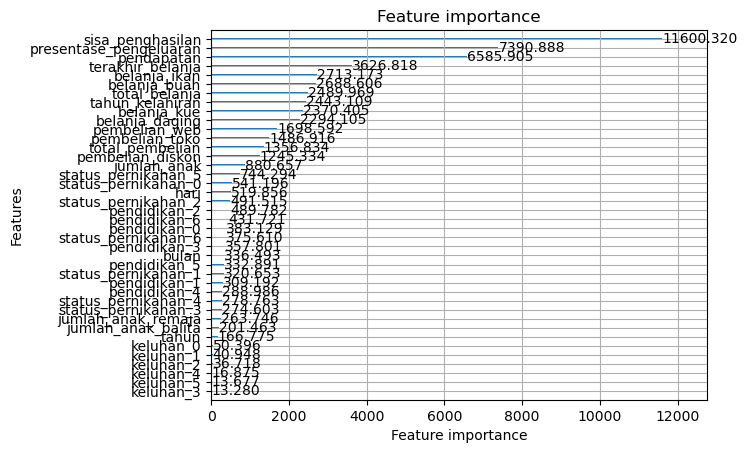

In [ ]:
lgb.plot_importance(pipe['algo'], importance_type='gain')

In [ ]:
df['keluhan'].value_counts()

0.0    3603
1.0      18
Name: keluhan, dtype: int64

## drop feature

In [ ]:
X = df.drop(['jumlah_promosi','tanggal_menjadi_anggota','keluhan'], axis=1)
y = df['jumlah_promosi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Pipeline
birthdate_cols = ['tahun_kelahiran'] # simple imputer with median
cat_cols = ['pendidikan','status_pernikahan'] # target encoder with MostFrequentImputer
float_cols = ['pendapatan', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue',
              'total_belanja', 'sisa_penghasilan', 'presentase_pengeluaran'] # mean imputer with log transformation
int_cols = ['total_pembelian', 'terakhir_belanja', 'jumlah_anak'] # median imputer
date_cols = ['hari', 'bulan'] # stochastic imputer with cosine scaler
year_cols = ['tahun'] # stochastic imputer

birthdate_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
    ('imputer', CategoryMostFrequentImputer()),
    ('encoder', TargetEncoder(target_type='continuous'))
])


float_pipeline = Pipeline([
    ('imputer', ClassMeanImputer())
])

int_pipeline = Pipeline([
    ('imputer', ClassMedianImputer())
])

preprocessor = ColumnTransformer([
    ('birthdate',birthdate_pipeline, birthdate_cols),
    ('float',float_pipeline, float_cols),
    ('cat', cat_pipeline, cat_cols),
    ('int',int_pipeline, int_cols)],
    remainder = "drop",verbose_feature_names_out=False).set_output(transform="pandas")

In [ ]:
# Define the number of splits
n_splits = 5  # You can adjust this as needed

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Custom scorer for f1_macro
scorer = make_scorer(f1_score, average='macro')

# Initialize dictionaries to store scores
average_cv_scores = {}

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
}

for name, model in models.items():
    print(f"Evaluating {name}...")

    # Perform cross-validation
    cv_scores = cross_val_score(Pipeline([
        ('pre', preprocessor),
        ('algo', model)
    ]), X, y, cv=skf, scoring=scorer)

    # Store average cross-validation score
    average_cv_scores[name] = np.mean(cv_scores)

    print(f"cv score: {np.mean(cv_scores):.4f}")

Evaluating Random Forest...
cv score: 0.6476
Evaluating LGBM...
cv score: 0.5886


In [ ]:
pipe = Pipeline([
    ('pre', preprocessor),
    ('algo', lgb.LGBMClassifier(random_state=42, class_weight='balanced'))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       290
           1       0.38      0.33      0.35       160
           2       0.51      0.52      0.51        97
           3       0.69      0.68      0.69       104
           4       0.68      0.83      0.75       103
           5       0.69      0.83      0.75       118
           6       0.55      0.67      0.61        83

    accuracy                           0.58       955
   macro avg       0.58      0.62      0.60       955
weighted avg       0.57      0.58      0.58       955



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

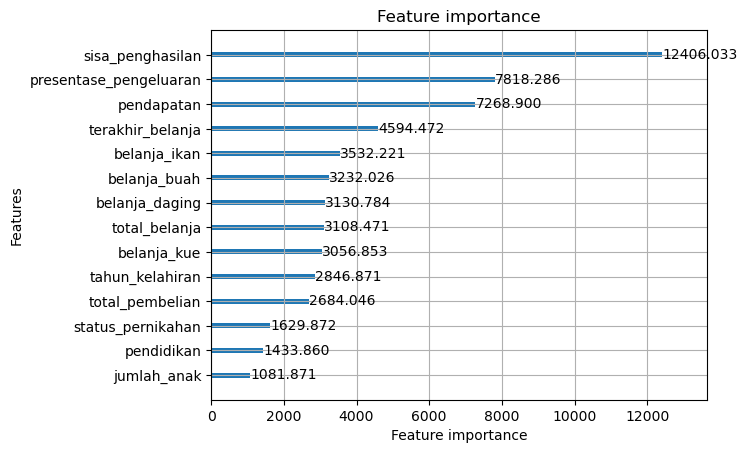

In [ ]:
lgb.plot_importance(pipe['algo'], importance_type='gain')

# vanila

In [ ]:
df

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,...,tanggal_menjadi_anggota,jumlah_promosi,jumlah_anak,total_pembelian,total_belanja,presentase_pengeluaran,sisa_penghasilan,hari,bulan,tahun
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,...,2014-05-05,2,1.0,7.0,382347.0,NaN,NaN,5.0,5.0,2014.0
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,...,2013-03-17,0,NaN,10.0,151725.0,0.001805,83911275.0,17.0,3.0,2013.0
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,...,NaT,1,0.0,8.0,624985.0,0.004901,126907579.0,NaN,NaN,NaN
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,...,NaT,4,0.0,15.0,1973840.0,0.011921,163605780.0,NaN,NaN,NaN
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,...,NaT,4,2.0,11.0,476553.0,0.004049,117226606.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,1955,Magister,Menikah,78199470.0,0.0,0.0,33.0,6069.0,25977.0,3856.0,...,NaT,5,0.0,1.0,41686.0,0.000533,78157784.0,NaN,NaN,NaN
3813,1947,Doktor,Rencana Menikah,109306000.0,0.0,1.0,44.0,0.0,50575.0,NaN,...,2014-06-09,1,1.0,9.0,NaN,NaN,NaN,9.0,6.0,2014.0
3814,1974,Magister,Menikah,104621000.0,0.0,2.0,68.0,2023.0,62713.0,8092.0,...,2013-11-07,0,2.0,12.0,72828.0,0.000696,104548172.0,7.0,11.0,2013.0
3815,1957,SMA,Rencana Menikah,110850000.0,1.0,1.0,67.0,18207.0,70805.0,24276.0,...,2013-06-30,0,2.0,9.0,NaN,NaN,NaN,30.0,6.0,2013.0


In [ ]:
X = df.drop(['jumlah_promosi', 'tanggal_menjadi_anggota', 'jumlah_anak', 'total_pembelian',
             'total_belanja', 'presentase_pengeluaran', 'hari', 'bulan', 'tahun'], axis=1)
y = df['jumlah_promosi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

num_pipeline = Pipeline([
    ('imputer', ClassMedianImputer())
])

cat_pipeline = Pipeline([
    ('imputer', CategoryMostFrequentImputer()),
    ('enc', TargetEncoder(target_type='continuous'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat',cat_pipeline, cat_cols)],
    remainder = "drop",verbose_feature_names_out=False).set_output(transform="pandas")

In [ ]:
# Define the number of splits
n_splits = 5  # You can adjust this as needed

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Custom scorer for f1_macro
scorer = make_scorer(f1_score, average='macro')

# Initialize dictionaries to store scores
average_cv_scores = {}

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
}

for name, model in models.items():
    print(f"Evaluating {name}...")

    # Perform cross-validation
    cv_scores = cross_val_score(Pipeline([
        ('pre', preprocessor),
        ('algo', model)
    ]), X, y, cv=skf, scoring=scorer)

    # Store average cross-validation score
    average_cv_scores[name] = np.mean(cv_scores)

    print(f"cv score: {np.mean(cv_scores):.4f}")

Evaluating Random Forest...
cv score: 0.7066
Evaluating LGBM...
cv score: 0.6247


In [ ]:
pipe = Pipeline([
    ('pre', preprocessor),
    ('algo', models['Random Forest'])
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.79      0.67       245
           1       0.55      0.25      0.34       137
           2       0.73      0.58      0.64        99
           3       0.82      0.73      0.77       103
           4       0.77      0.94      0.85       127
           5       0.81      0.89      0.85       143
           6       0.75      0.59      0.66       101

    accuracy                           0.70       955
   macro avg       0.72      0.68      0.68       955
weighted avg       0.70      0.70      0.68       955



In [ ]:
y_test.value_counts()

0    245
5    143
1    137
4    127
3    103
6    101
2     99
Name: jumlah_promosi, dtype: int64

In [ ]:
df.jumlah_promosi.value_counts(normalize=True)

0    0.257532
5    0.145926
1    0.134923
4    0.134923
3    0.123657
2    0.101912
6    0.101127
Name: jumlah_promosi, dtype: float64

# tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
df2

,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,sisa_penghasilan,pendidikan,status_pernikahan
2630,1975,133777000.0,0.0,1.0,3.0,161840.0,940695.0,32368.0,18207.0,1.0,8.0,6.0,0.0,132623890.0,2.697307,2.164677
1044,1973,81933568.0,0.0,0.0,93.0,18849.0,41613.0,30118.0,7354.0,2.0,1.0,4.0,0.0,81835634.0,2.977642,2.697821
2820,1980,164970988.0,0.0,0.0,22.0,363879.0,1412859.0,282757.0,115979.0,0.0,2.0,8.0,0.0,162795514.0,2.697307,2.739074
69,1953,99736302.0,0.0,1.0,80.0,10955.0,125485.0,21910.0,18331.0,0.0,4.0,6.0,0.0,99559621.0,2.654327,2.943316
3705,1973,49603089.0,0.0,0.0,35.0,14044.0,31014.0,53732.0,11686.0,2.0,1.0,2.0,0.0,49492613.0,1.342773,2.697821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1962,77546550.0,1.0,0.0,33.0,5350.0,100301.0,12213.0,0.0,5.0,3.0,2.0,0.0,77428686.0,1.986374,2.943316
1294,1971,92991000.0,1.0,1.0,80.0,4046.0,163863.0,24276.0,10115.0,6.0,5.0,5.0,0.0,92788700.0,2.049111,2.697821
860,1961,116048413.0,0.0,1.0,106.0,135321.0,1035674.0,170439.0,117935.0,5.0,2.0,9.0,0.0,114589044.0,1.986374,2.161304
3507,1957,166648399.0,0.0,0.0,40.0,112547.0,1693070.0,376294.0,266122.0,0.0,8.0,11.0,0.0,164200366.0,2.222129,2.165878


In [ ]:
df[['belanja_buah','belanja_daging','belanja_ikan','belanja_kue']].std(skipna=True,axis=1)

0       111177.608862
1        32760.734580
2        75548.842865
3       750523.251287
4       130887.581986
            ...      
3812     10416.813860
3813     29199.489864
3814     29869.237051
3815     28775.945412
3816    183063.802552
Length: 3817, dtype: float64

In [ ]:
prep_pipeline = Pipeline([
    ("preprocessor",preprocessor)
])
df2 = prep_pipeline.fit_transform(X_train,y_train)
X_test2 = prep_pipeline.transform(X_test)

def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

model_dl = tf.keras.Sequential([
    tf.keras.layers.Dense(50,input_shape=(df2.shape[1],), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax')
])


model_dl.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_dl.fit(df2.astype('float32'), y_train.astype('float32'),
                    epochs=50,
                    validation_data=(X_test2, y_test))
pred_y = np.argmax(model_dl.predict(X_test2), axis=1)
print(classification_report(y_test, pred_y))
print(f1_score(y_test, pred_y, average='macro'))

Epoch 1/50
90/90 [==============================] - 1s 5ms/step - loss: 1.8696 - accuracy: 0.2809 - val_loss: nan - val_accuracy: 0.2272
Epoch 2/50
90/90 [==============================] - 0s 3ms/step - loss: 1.8117 - accuracy: 0.3054 - val_loss: nan - val_accuracy: 0.2691
Epoch 3/50
90/90 [==============================] - 0s 3ms/step - loss: 1.7894 - accuracy: 0.3138 - val_loss: nan - val_accuracy: 0.2764
Epoch 4/50
90/90 [==============================] - 0s 4ms/step - loss: 1.7770 - accuracy: 0.3187 - val_loss: nan - val_accuracy: 0.2806
Epoch 5/50
90/90 [==============================] - 0s 5ms/step - loss: 1.7638 - accuracy: 0.3103 - val_loss: nan - val_accuracy: 0.2754
Epoch 6/50
90/90 [==============================] - 0s 3ms/step - loss: 1.7611 - accuracy: 0.3187 - val_loss: nan - val_accuracy: 0.2743
Epoch 7/50
90/90 [==============================] - 0s 5ms/step - loss: 1.7423 - accuracy: 0.3354 - val_loss: nan - val_accuracy: 0.2754
Epoch 8/50
90/90 [=======================

c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r